In [1]:
!pip install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import cv2
import torch
import yaml
import math 
import time
import pandas as pd
import numpy as np
from roboflow import Roboflow
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display, Image, clear_output
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
print(f"The pytorch verison is : {torch.__version__}")
print(f"The CUDA is available or not : {torch.cuda.is_available()}")
print(f"How many GPU is available :{torch.cuda.device_count()}")
print(f"Name of using GPU is : {torch.cuda.get_device_name()}")

# display using gpu info 
a=!nvidia-smi
print("The using GPU information :")
print("\n".join(a))

The pytorch verison is : 2.6.0+cu124
The CUDA is available or not : True
How many GPU is available :1
Name of using GPU is : Tesla P100-PCIE-16GB
The using GPU information :
Thu Jun  5 08:25:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       3MiB /  

# Download Dataset from Roboflow :

In [4]:
private_api_key="MrxQVHpTMv81YWVp7O2Y"
workspace_name="brain-tumor-detection-wsera"
proj_name="tumor-detection-ko5jp"
dataset_version=8

In [5]:
def prepare_and_download_dataset(private_api_key,workspace_name, proj_name, dataset_version):
    if not private_api_key or not workspace_name or not proj_name or not dataset_version:
        print("Some information has not been given about roboflow")
        return None
        
    print (f"Downloading custom dataset from roboflow [{workspace_name}]:")

    try:
        # initializing roboflow clint
        try:
            rf=Roboflow(api_key=private_api_key)
        except Exception as e:
            print(f"Error occurred during initializing roboflow client: {e}")
            return None 

        # try to access workspace 
        try:
            work_space=rf.workspace(workspace_name)
        except Exception as e:
            print(f"Error occurred during access to workspace {workspace_name}: {e}")
            return None 

        # try to access project
        try:
            pro_name= work_space.project(proj_name)
        except Exception as e:
            print(f"Error occurred during access to project {proj_name}: {e}")
            return None 

        # download the dataset
        try:
            dataset=pro_name.version(dataset_version).download("yolov12")
        except Exception as e:
            print(f"Error occurred during download the dataset version {dataset_version}: {e}")
            return None 
    
        dataset_path = dataset.location 

        # Open the data.ymal file and recheck and update the train valid and test image data path 
        try:
            with open(os.path.join(dataset_path, "data.yaml"), 'r') as f :
                data = yaml.safe_load(f)

            data["train"]=os.path.join(dataset_path, "train/images")
            data["val"]=os.path.join(dataset_path, "valid/images")
            data["test"]=os.path.join(dataset_path, "test/images")

            with open(os.path.join(dataset_path, "data.yaml"), 'w') as f :
                yaml.dump(data, f)
        except Exception as e:
            print(f"Error occurred during update the data.yaml file: {e}")
            return None        

        # Information about dataset 
        print(f"Number of class : {len(data['names'])}")
        print(f"Name of all classes : {data['names']}")
        print(f"Total number of training images : {len(os.listdir(data['train']))}")
        print(f"Total number of valid images : {len(os.listdir(data['val']))}")
        print(f"Total number of test images : {len(os.listdir(data['test']))}")

        return  dataset_path

    except Exception as e:
        print(f"Error occurred during download the dataset: {e}")
        return None 

In [6]:
# Download and Prepare Dataset
dataset_path = prepare_and_download_dataset(private_api_key=private_api_key,workspace_name=workspace_name, proj_name=proj_name, dataset_version=dataset_version)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tumor-Detection-8 in yolov12:: 100%|██████████| 3924/3924 [00:00<00:00, 8788.15it/s]

Number of class : 5
Name of all classes : ['NO_tumor', 'glioma', 'meningioma', 'pituitary', 'space-occupying lesion-']
Total number of training images : 1370
Total number of valid images : 395
Total number of test images : 191


# Fine-Tune YOLOv12n Model :

In [7]:
def fine_tune_function(dataset_path, model_name, epochs, batch_size, proj_dir, run_name):
    if not dataset_path:
        print("dataset_path cant found")
        return None, None, None
    
    # load the YOLOv12n pretrained model 
    try:
        print("Loading the model from ultralytics :")
        model=YOLO(model_name)
    except Exception as e:
        print(f"Error occurred during load the model: {e}")
        return None, None, None

    # create project directory 
    try:
        print("creating project directory :")
        results_dir=os.path.join(proj_dir, run_name)
        print(f"Project directory has been created to this [{results_dir}] path.")
    except Exception as e:
        print(f"Error occurred during creating project project directory: {e}")
        return None, None, None
        
    # fine tune the model
    try:
        print(f"The training results will be saved to this [{results_dir}] path.")
        print("Starting The Training..................................................................")
        start_time=time.time()
        results=model.train(data=os.path.join(dataset_path, "data.yaml"),
                            seed=42,
                            epochs=epochs,
                            patience=300,
                            batch=batch_size,
                            imgsz=640,
                            device=0, # for multi GPU device=[0,1]
                            workers=4,

                            # Ultralytice by defult augmentation parameters
                            # degrees=10.0,  # Rotattion (±10°)
                            # flipud=0.0,    # No vertical flip
                            # fliplr=0.5,    # Horizontal flip (50% chance)
                            # hsv_h=0.0,     # No hue change
                            # hsv_s=0.0,     # No saturation change
                            # hsv_v=0.4,     # Contrast adjustment (brightness)
                            # translate=0.0, # No translate
                            # scale=0.0,     # No scaling
                            # shear=0.0,     # No shearing
                            # perspective=0.0, # No perspective
                            # mosaic=0.0,    # Disable mosaic
                            # mixup=0.0,     # Disable mixup
                            # copy_paste=0.0,# Disable copy_paste
        
                            # Other training parameters
                            lr0=0.001,
                            lrf=0.1,
                            momentum=0.98,
                            weight_decay=0.005,
                            warmup_epochs=3,
                            warmup_momentum=0.9,
                            warmup_bias_lr=0.1,
                            cos_lr=True,

                            # Validation & Saving
                            save=True,
                            #save_period=10,
                            val=True,
                            plots=True,
                           
                            # Project Organizing 
                            exist_ok=True, # allows overwriting of an existing project/name directory
                            project=proj_dir, # name of the project directory where training outputs are saved
                            name=run_name, # used for creating a subdirectory within the project folder, where training logs and outputs are stored
                           
                            verbose=True)  
        
        total_training_time=time.time()-start_time
        print(f"Training has been completed.\nTotal training time : {total_training_time:.2f} sec, {total_training_time/60:.2f} min, {total_training_time/3600:.2f} hours")
    except Exception as e:
        print(f"Error occurred during train the model: {e}")
        return None, None, None

    # Save the best model in the dedicated path 
    try:
        print("Saving the fine tune model :")
        best_model_path=os.path.join(proj_dir, run_name, "weights/best.pt")
        if os.path.exists(best_model_path): 
            print(f"The fine tune model has been saved to this [{best_model_path}] path")
        else:
            print(f"WARNING-The fine tune model has 'NOT' been saved to this [{best_model_path}] path")
            return None,None, None
    except Exception as e:
        print(f"Error occurred during save the fine tune model: {e}")
        return None, None, None

    return best_model_path, run_name, results

In [8]:
# Fine tune the model using own custome dataset
best_model_path, run_name, training_results = fine_tune_function(dataset_path="/kaggle/working/Tumor-Detection-8", 
                   model_name="yolo12n.pt" , 
                   epochs=300, 
                   batch_size=-1, # this will automatically determines the optimal batch size based on available GPU memory                     
                   proj_dir="/kaggle/working/runs/detect",
                   run_name="Brain-Tumor-Detection")

Loading the model from ultralytics :


100%|██████████| 5.34M/5.34M [00:00<00:00, 132MB/s]

creating project directory :
Project directory has been created to this [/kaggle/working/runs/detect/Brain-Tumor-Detection] path.
The training results will be saved to this [/kaggle/working/runs/detect/Brain-Tumor-Detection] path.
Starting The Training..................................................................
Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/Tumor-Detection-8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.98, mosaic=1.0, multi_scale=False, name=Brain-Tumor-Detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=300, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=/kaggle/working/runs/detect

100%|██████████| 755k/755k [00:00<00:00, 43.8MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 146MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 917.6±307.6 MB/s, size: 30.4 KB)


train: Scanning /kaggle/working/Tumor-Detection-8/train/labels... 1370 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1370/1370 [00:01<00:00, 1209.74it/s]

train: /kaggle/working/Tumor-Detection-8/train/images/no_tumor_914_jpg.rf.6714544aee2bde5213fd2c366dff62aa.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/Tumor-Detection-8/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1456, len(boxes) = 1461. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.12G reserved, 0.07G allocated, 15.70G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2569023       6.484         0.621         52.66         181.1        (1, 3, 640, 640)                    list
     2569023       12.97         0.881         40.91         99.01        (2, 3, 640, 640)                    list
     2569023       25.94         1.382         44.78         132.1        (4, 3, 640, 640)                    list
     2569023       51.87         2.282         48.06         117.6        (8, 3, 640, 640)                    list
     2569023       103.

train: Scanning /kaggle/working/Tumor-Detection-8/train/labels.cache... 1370 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1370/1370 [00:00<?, ?it/s]

train: /kaggle/working/Tumor-Detection-8/train/images/no_tumor_914_jpg.rf.6714544aee2bde5213fd2c366dff62aa.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1456, len(boxes) = 1461. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 341.2±139.8 MB/s, size: 29.6 KB)


val: Scanning /kaggle/working/Tumor-Detection-8/valid/labels... 395 images, 0 backgrounds, 0 corrupt: 100%|██████████| 395/395 [00:00<00:00, 612.93it/s]

val: New cache created: /kaggle/working/Tumor-Detection-8/valid/labels.cache


Plotting labels to /kaggle/working/runs/detect/Brain-Tumor-Detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.98' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0059375), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/detect/Brain-Tumor-Detection
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      7.36G     0.9363      3.233      1.296          3        640: 100%|██████████| 37/37 [00:21<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


                   all        395        415    0.00122      0.287      0.159     0.0864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      7.32G     0.9975      2.004      1.291          3        640: 100%|██████████| 37/37 [00:20<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        395        415      0.907      0.146      0.272      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      7.36G     0.9843      1.761      1.286          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


                   all        395        415       0.59      0.308      0.262      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      7.37G     0.9811      1.568      1.286          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        395        415       0.68      0.264      0.274      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      7.36G     0.9829      1.354      1.293          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.556      0.374      0.328      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      7.37G     0.9504      1.222      1.264          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        395        415      0.866      0.453      0.525       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      7.32G     0.9179      1.135      1.233          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.731      0.565       0.55      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      7.37G     0.8911      1.051      1.227          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.653      0.509      0.499      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      7.35G     0.9036      1.014      1.237          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415       0.78      0.591       0.59       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      7.36G     0.8843     0.9971       1.22          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.831      0.525      0.586      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      7.36G     0.8565     0.9363      1.204          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.806      0.583      0.611      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      7.37G      0.848      0.923      1.212          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415        0.7        0.6      0.583       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      7.36G     0.8564     0.9055      1.214          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        395        415      0.744      0.481      0.536      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      7.37G     0.8452     0.8745      1.203          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.831      0.541      0.579      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      7.36G     0.8628     0.8489      1.233          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.797      0.535      0.587      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      7.33G     0.8397     0.8183      1.229          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.851      0.549      0.601      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      7.34G     0.9317     0.8818      1.324          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.788      0.554      0.575      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      7.36G     0.7963     0.8135      1.182          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.818      0.584      0.625      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      7.36G     0.8409     0.7984      1.195          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.745      0.527      0.555      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      7.32G     0.7869     0.7846      1.159          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.847      0.545      0.589      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      7.36G     0.7832     0.7815      1.162          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.817      0.563      0.597      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      7.37G     0.7979     0.7667      1.166          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.767      0.592      0.591      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300       7.3G     0.7625     0.7183      1.161          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        395        415      0.804      0.514      0.557      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      7.36G     0.7878     0.7407      1.173          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        395        415      0.845      0.526      0.596      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300       7.3G     0.7925     0.7203       1.18          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.828      0.574      0.609      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      7.36G     0.7687     0.7197      1.158          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.828      0.636      0.652      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      7.37G     0.7839     0.7177       1.17          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.785      0.568      0.645      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      7.37G     0.7789     0.6967      1.181          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        395        415      0.863      0.584      0.628      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      7.32G     0.7459     0.6846      1.151          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.829      0.623      0.659      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      7.36G     0.7482     0.6978      1.147          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        395        415      0.849      0.552      0.611      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      7.37G      0.766     0.6761       1.15          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.861      0.611      0.645      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      7.37G     0.7525     0.7247      1.142          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.795      0.599      0.618      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      7.36G     0.7251     0.6786      1.141          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.857      0.562      0.613      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      7.35G     0.7215     0.7042      1.125          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

                   all        395        415      0.885      0.582      0.638      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      7.36G     0.7699     0.7161      1.164          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        395        415       0.82      0.586      0.634      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      7.37G     0.7525     0.6856       1.16          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.797      0.619      0.631       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300       7.3G     0.7349     0.6465      1.127          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.821      0.605      0.632      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      7.33G      0.698     0.6291      1.122          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.864      0.574      0.655      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      7.36G     0.7369     0.6451      1.153          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.808      0.593      0.613      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      7.37G     0.7107     0.6533      1.123          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.782      0.626      0.604      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      7.36G     0.7023     0.6356      1.127          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.808      0.592      0.604      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      7.35G     0.7233     0.6393      1.136          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        395        415      0.859       0.56      0.625      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      7.31G     0.7376     0.6526      1.149          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.835      0.558      0.609      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      7.36G     0.7153      0.639      1.139          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.843      0.604      0.646      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      7.32G     0.7232     0.6495      1.132          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.868      0.589      0.629      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      7.37G      0.711     0.6478       1.14          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        395        415      0.807      0.634      0.649      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      7.36G     0.6976      0.646      1.136          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.822       0.63       0.67       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      7.33G     0.6983     0.6262      1.123          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.818      0.603      0.635      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300       7.3G     0.7102     0.6207      1.115          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        395        415      0.893      0.583      0.646      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      7.33G     0.6825     0.6915      1.133          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.612      0.713      0.657      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      7.34G     0.6689     0.5874      1.101          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.876      0.584      0.664      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      7.36G     0.6973     0.6126      1.125          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.869      0.595      0.634      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300       7.3G     0.6704     0.6114      1.108          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.773      0.626      0.633      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      7.33G      0.713     0.5945      1.137          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.822      0.586      0.628        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300       7.3G     0.6665     0.5836      1.114          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.585      0.706      0.661      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      7.37G     0.6757     0.5769       1.11          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        395        415      0.846      0.618      0.646      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      7.36G      0.678     0.5844      1.098          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.827       0.62      0.646      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      7.31G     0.6552     0.5674      1.094          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.871      0.616      0.653      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      7.36G     0.6938     0.5876      1.134          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.871      0.625      0.653      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      7.37G     0.6498     0.5802      1.104          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.858      0.628       0.65      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      7.31G     0.6568     0.5502      1.114          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.884      0.611      0.658      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      7.37G     0.6738      0.565      1.104          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415       0.81      0.646      0.643      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      7.36G     0.6707     0.5678      1.116          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        395        415      0.852       0.61      0.646      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      7.33G     0.6596     0.5461      1.118          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.854      0.612      0.649      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      7.31G     0.6283     0.5513      1.078          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.808      0.607      0.615      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      7.38G     0.6489      0.541      1.102          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.813      0.607      0.636      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      7.32G     0.6407     0.5363      1.087          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415       0.85      0.591      0.636      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      7.37G     0.6115     0.5054      1.062          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.844      0.614      0.652       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      7.36G     0.6619     0.5462      1.107          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.854      0.606      0.644      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      7.36G     0.6514       0.56      1.084          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        395        415      0.878      0.621      0.657      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300       7.3G       0.66     0.5422      1.089          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.681      0.677      0.658      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      7.37G     0.6425     0.5426      1.092          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415       0.84      0.638      0.656      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300       7.3G     0.6247     0.5526       1.08          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.842      0.645      0.661      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      7.33G     0.6545     0.5594      1.094          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.859      0.655      0.661      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      7.35G     0.6223     0.5198      1.076          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.886      0.603      0.651      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      7.37G     0.6243     0.5127      1.084          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.662      0.631      0.655      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      7.36G     0.6108     0.5201      1.074          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        395        415      0.809       0.65      0.644       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      7.36G     0.6402     0.5161      1.107          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415       0.67      0.614      0.651      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300       7.3G     0.6329     0.5491      1.079          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.845      0.649      0.673      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      7.37G     0.6289     0.5382      1.084          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.642      0.653      0.662      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      7.31G     0.6186     0.5186      1.079          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.588      0.668      0.646      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      7.33G     0.6142     0.5173      1.075          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        395        415      0.857      0.607      0.647      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300       7.3G     0.6167     0.5185      1.084          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        395        415      0.856      0.617      0.657      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      7.36G     0.5904     0.4853       1.08          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.877      0.601      0.644      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      7.32G     0.6464     0.5168      1.084          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.845      0.601      0.632       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      7.37G      0.609      0.507      1.057          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.692      0.615      0.657       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      7.32G     0.6062      0.496      1.064          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.884      0.602      0.666       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      7.31G     0.5759     0.4936      1.044          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.818      0.637      0.646      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      7.34G     0.6112     0.5232      1.066          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.664      0.617      0.647      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      7.33G     0.5848     0.4896      1.057          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        395        415      0.617      0.683      0.644      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300       7.3G     0.6407      0.502      1.082          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.873      0.563      0.634      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      7.36G     0.6148     0.5182      1.082          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.848        0.6      0.623      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      7.36G      0.586     0.4689      1.052          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415       0.85      0.638      0.645      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      7.37G     0.5787      0.437       1.06          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.633      0.669      0.649      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      7.35G     0.6072      0.483      1.068          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.601      0.682      0.641      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      7.36G      0.591     0.4786      1.056          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        395        415      0.864      0.605      0.653      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      7.36G     0.6063     0.4842      1.065          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.619      0.611      0.622      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      7.33G     0.5769     0.4762      1.044          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415       0.84      0.611      0.658      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300       7.3G     0.5796     0.4596      1.053          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.871      0.637      0.663       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      7.34G     0.5799     0.4661      1.051          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.598        0.7      0.655      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      7.36G     0.5603      0.458      1.037          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.631      0.638      0.643      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      7.31G      0.586     0.4768      1.061          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.856      0.633      0.644      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      7.36G     0.5928     0.4872       1.08          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.888      0.618      0.666      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      7.37G     0.5762     0.4727      1.073          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.641      0.645       0.67      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      7.36G     0.5657     0.4555      1.047          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.885       0.63      0.671      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      7.37G     0.5662     0.4451      1.053          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.848      0.632      0.645       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300       7.3G     0.5697     0.4713      1.047          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.663       0.61      0.636      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      7.36G      0.551     0.4561      1.035          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.877      0.629      0.651      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      7.36G     0.5635     0.4451      1.045          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.878      0.625      0.666      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      7.37G     0.5614     0.4859      1.032          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.873        0.6      0.657      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      7.37G     0.5568     0.4646       1.03          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        395        415      0.649      0.647      0.661      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      7.31G     0.5837     0.4689       1.06          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        395        415      0.692      0.625       0.66      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      7.35G     0.5666     0.4534      1.036          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.633       0.62      0.626      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      7.33G     0.5739     0.4916      1.062          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.853      0.613      0.636      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      7.37G     0.5768     0.4758      1.045          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        395        415      0.683      0.598       0.65      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      7.31G     0.6097     0.4792      1.083          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415      0.626      0.613      0.633      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      7.33G     0.5606     0.4567      1.049          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.874      0.605      0.631      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      7.33G     0.5777      0.452      1.053          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.844      0.629      0.646      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300       7.3G     0.5465     0.4601      1.036          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.854      0.631      0.652      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      7.33G     0.5218     0.4129      1.019          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.621      0.625      0.627      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      7.36G     0.5463     0.4357      1.035          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.646      0.632      0.647      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      7.31G     0.5794     0.4306      1.048          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.889      0.603       0.64      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      7.32G     0.5312      0.409      1.021          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.857      0.625      0.655      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      7.37G      0.547     0.4679      1.056          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.621      0.652      0.655      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      7.36G     0.5175     0.4414      1.032          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.889      0.619      0.658       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      7.35G     0.5439     0.4177       1.02          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.904       0.62      0.668      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      7.36G     0.5546     0.4041      1.046          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.918      0.626      0.679      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      7.32G     0.5409     0.4021      1.034          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.888      0.615      0.664       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      7.31G      0.538     0.4141      1.021          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.866       0.63      0.659      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      7.37G     0.5192     0.4077      1.015          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415       0.68      0.638      0.659      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      7.36G     0.5422     0.4134      1.055          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.618       0.73      0.688      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      7.37G      0.536     0.4226      1.027          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.888      0.632      0.665      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      7.36G     0.5527     0.4429      1.031          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.903      0.642      0.677      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      7.37G     0.5315     0.4143      1.042          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.679      0.638      0.667      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300       7.3G     0.5168      0.406       1.02          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        395        415      0.848      0.638      0.662      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      7.36G     0.5383     0.4241      1.026          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415       0.63      0.658      0.655      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300       7.3G     0.5288      0.408      1.026          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.887      0.604      0.649      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      7.33G     0.5612     0.4214       1.05          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415       0.67      0.627      0.658      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      7.32G     0.5296     0.4055      1.026          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        395        415      0.659      0.638      0.667      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      7.31G     0.5458     0.4241      1.037          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.882      0.606      0.649      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      7.36G     0.5425     0.4179      1.038          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.663      0.645      0.666      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      7.38G     0.5265     0.4018      1.021          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        395        415      0.867      0.628      0.667      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      7.36G     0.5139      0.393       1.01          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.679      0.641      0.666      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      7.31G     0.5172     0.4096      1.015          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.878      0.614      0.657       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      7.36G     0.5142      0.418      1.017          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.889      0.633      0.665      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      7.37G     0.5194     0.3824      1.017          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        395        415      0.637      0.656       0.66      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      7.36G     0.4997     0.3788      1.017          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.864      0.647      0.659      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      7.37G     0.5057      0.398      1.007          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.891      0.595      0.657      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      7.32G     0.5071     0.3817      1.002          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        395        415      0.844      0.644      0.669      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      7.37G     0.5279     0.3838       1.02          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.623      0.717      0.667      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300       7.3G     0.5018     0.3796      0.998          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415       0.66       0.63      0.649      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      7.36G     0.5155     0.3865      1.016          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.864      0.619      0.659      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      7.36G     0.5223     0.3865      1.018          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.885      0.631      0.664      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      7.31G      0.502     0.3769      1.022          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.869      0.647      0.663      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      7.34G     0.5417      0.434       1.03          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.897       0.64      0.662      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      7.33G     0.4988     0.3866      1.013          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        395        415      0.855      0.652      0.661      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300       7.3G     0.4797     0.3595     0.9917          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.853      0.658      0.662      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      7.33G     0.4918     0.3618      1.005          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.868      0.648      0.663       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300       7.3G     0.4854     0.3744      0.995          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.659      0.646      0.669      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      7.36G     0.4939     0.3824     0.9965          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415       0.87      0.635      0.648       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      7.36G     0.4952     0.3728     0.9975          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.728      0.697      0.681      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      7.37G     0.4896     0.3809      1.001          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.676      0.695      0.681      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      7.36G     0.4901     0.3767      1.006          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        395        415      0.648      0.715      0.683      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      7.33G      0.485     0.3636     0.9968          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.612      0.711      0.666      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300       7.3G     0.4804     0.5074     0.9748          0        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        395        415      0.649      0.712      0.681      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      7.36G     0.4894     0.3553      1.009          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.657      0.629      0.654      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300       7.3G     0.4945     0.3629      1.001          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.847      0.637      0.666      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      7.37G     0.4965      0.386     0.9994          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.889       0.63      0.682       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300       7.3G     0.4837      0.384      1.006          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.672      0.643      0.669       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      7.37G     0.4692     0.3544     0.9711          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.865      0.647      0.676      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300       7.3G      0.482     0.3571     0.9875          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.896      0.627      0.665      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      7.37G     0.5005      0.361      1.011          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.921      0.612       0.67      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      7.36G     0.4733     0.3483     0.9892          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.657      0.627      0.662      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      7.31G      0.513     0.5055      1.016          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.878      0.642      0.663      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300       7.3G     0.4812     0.3674      1.007          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.634      0.699      0.661      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      7.33G     0.4735     0.3576     0.9824          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.665       0.64      0.663      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      7.36G     0.4589     0.3598     0.9812          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        395        415      0.716      0.623      0.667      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      7.31G      0.465     0.3565     0.9844          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.873      0.618      0.665      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300       7.3G     0.4869     0.3693      1.017          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415       0.66      0.702      0.686      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      7.33G      0.463     0.3508     0.9963          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.669      0.727      0.714      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      7.36G     0.4622     0.3451     0.9817          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.707       0.68       0.67      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      7.36G     0.4547     0.3734     0.9802          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.659      0.652      0.662      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      7.36G     0.4532     0.3509     0.9871          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.626      0.714      0.672      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      7.31G     0.4565      0.344     0.9817          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.683      0.702      0.702      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300       7.3G     0.4588     0.3366     0.9774          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.626      0.708      0.665      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      7.33G     0.4495     0.3437     0.9756          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.624      0.703       0.66      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      7.36G     0.4521     0.3453     0.9752          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.872      0.622      0.649      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      7.37G     0.4446     0.3374      0.979          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.866      0.623      0.656      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      7.32G     0.5057     0.3552      1.081          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.875      0.603      0.642      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      7.37G     0.4687     0.3763     0.9942          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.644      0.627      0.644      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300       7.3G     0.4662     0.3328     0.9829          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.616      0.681      0.651       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      7.33G     0.4407     0.3262     0.9704          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.698      0.695      0.682      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      7.36G     0.4426     0.3313     0.9708          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415       0.79       0.69      0.711       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      7.31G     0.4497     0.3384     0.9812          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.737      0.668      0.675      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      7.31G     0.4583     0.3407     0.9831          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        395        415      0.696      0.694      0.669      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      7.33G     0.4432     0.3605     0.9856          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        395        415      0.662      0.693      0.672      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      7.36G     0.4509      0.337     0.9725          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.786      0.693      0.687      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      7.36G     0.4363     0.3231      0.979          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.673      0.703      0.668      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      7.36G     0.4256     0.3161     0.9637          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        395        415      0.686      0.684      0.671      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      7.37G     0.4391      0.331     0.9728          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.648      0.704      0.699      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      7.31G     0.4356      0.329     0.9668          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        395        415      0.845      0.647      0.661      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      7.33G     0.4296     0.3407     0.9586          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.882      0.631       0.67      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300       7.3G      0.429      0.326     0.9711          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.878      0.629      0.662      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      7.33G     0.4402     0.3337     0.9677          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.893       0.62      0.668      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      7.32G     0.4396     0.3246     0.9752          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415       0.87      0.611      0.657      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      7.31G     0.4317     0.3101     0.9799          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.861      0.629      0.658      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300       7.3G     0.4197     0.3091     0.9602          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.639      0.648      0.659      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      7.33G     0.4137     0.3079     0.9511          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

                   all        395        415      0.645       0.72      0.675       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300       7.3G     0.4407     0.3311     0.9762          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.885      0.606      0.665      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      7.33G     0.4306     0.3206     0.9749          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415       0.67      0.705      0.677      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300       7.3G     0.4271     0.3343     0.9753          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.638      0.718      0.674      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      7.36G     0.4524     0.3426     0.9897          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.636      0.729      0.681       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      7.36G     0.4143     0.3036     0.9674          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.635      0.716      0.666      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      7.31G     0.4218     0.3092     0.9545          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.873      0.638      0.672      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      7.31G     0.4242     0.3068     0.9609          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        395        415      0.625      0.707      0.661      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      7.33G     0.4354     0.3171     0.9634          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.649      0.697      0.664      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      7.36G     0.4185     0.3079     0.9616          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.859      0.637      0.664      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      7.33G     0.4295     0.3558     0.9675          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.888      0.634      0.668      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      7.36G     0.4168     0.3025     0.9833          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.907      0.617      0.676      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      7.37G     0.4239     0.3137     0.9641          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.901      0.616      0.657      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      7.31G     0.4031     0.2923     0.9508          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        395        415      0.838      0.639      0.651       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      7.33G     0.4023     0.3023     0.9482          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415       0.85      0.627      0.657      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      7.35G     0.4233     0.3098     0.9648          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.851      0.647      0.655      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      7.33G     0.3974     0.3023      0.951          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.846      0.656      0.656      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      7.32G     0.4081     0.3088      0.958          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.749      0.722      0.709      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      7.37G      0.397      0.301     0.9496          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.678      0.711       0.68      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300       7.3G     0.4175      0.306     0.9608          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.876      0.641      0.672      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      7.37G     0.4113     0.3055     0.9472          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        395        415      0.914      0.619      0.664      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300       7.3G     0.4358       0.33     0.9995          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.877      0.631       0.65      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      7.33G     0.4104     0.3058     0.9475          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.903      0.626      0.666      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300       7.3G     0.4229      0.311      0.967          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.903      0.615      0.657      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      7.36G      0.442     0.3113     0.9767          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.881      0.624      0.667      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300       7.3G     0.3859     0.2961     0.9429          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.889      0.614       0.66      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      7.34G     0.3833     0.2825      0.942          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.894      0.627      0.662       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      7.35G     0.4174     0.3359     0.9686          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        395        415      0.889      0.628       0.66      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      7.33G     0.4111     0.2962     0.9625          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415       0.89       0.62      0.657      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      7.36G     0.4016     0.3038     0.9432          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.873      0.636      0.666      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      7.36G     0.4159      0.381      0.974          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.884      0.631      0.661      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      7.36G     0.4089     0.2953     0.9559          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        395        415      0.676      0.636      0.663      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      7.36G     0.3956     0.2964     0.9482          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.878      0.634       0.67      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      7.36G     0.3951     0.2875     0.9464          9        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        395        415      0.864      0.638      0.661      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      7.33G     0.3937     0.2926     0.9414          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.865      0.652      0.665      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      7.37G     0.3908     0.2839     0.9454          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.864      0.625      0.645      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      7.37G     0.3975     0.2936      0.947          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        395        415       0.86      0.649      0.655      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300       7.3G     0.3909     0.2887     0.9494          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.861      0.626      0.648      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      7.33G     0.4032     0.2939     0.9509          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        395        415      0.898      0.603      0.656      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      7.36G     0.3992     0.2892     0.9519          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.861       0.62      0.649      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      7.33G     0.4026      0.289     0.9507          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.866      0.621      0.651      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300       7.3G     0.4048     0.2928     0.9416          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.858      0.633      0.653      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      7.36G     0.3947     0.2929     0.9488          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.861      0.625      0.653      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      7.36G     0.3938     0.2841     0.9521          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.884      0.624      0.659      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      7.31G     0.3987     0.2926     0.9569          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.884      0.619      0.652      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      7.32G      0.365     0.2676     0.9301          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        395        415      0.858      0.636      0.654      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      7.36G     0.3902     0.3026     0.9495          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        395        415      0.872      0.623      0.655      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      7.36G     0.3725     0.2644      0.933          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.849       0.64      0.654      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      7.31G     0.4456     0.3918     0.9844          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        395        415      0.872      0.623      0.648      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      7.36G     0.4072     0.2892     0.9574          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.886      0.621      0.653      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      7.37G     0.3783     0.2716     0.9289          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        395        415       0.69      0.637      0.664      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300       7.3G      0.391     0.2847     0.9337          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        395        415      0.657      0.709      0.703      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      7.34G       0.39     0.2981     0.9498          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        395        415      0.639      0.713      0.673      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      7.36G     0.3741     0.2767     0.9262          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        395        415      0.872      0.623      0.651      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      7.35G     0.3868     0.2777     0.9366          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415      0.882      0.621      0.649      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300       7.3G     0.3827     0.2759     0.9436          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        395        415      0.897      0.617      0.652      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      7.33G     0.3822     0.2829     0.9406          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.677       0.63      0.654      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      7.32G     0.3755     0.2755     0.9352          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.866       0.63      0.655      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      7.32G      0.375     0.2711     0.9431          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415      0.907      0.612      0.656      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      7.36G     0.3757     0.2766     0.9297          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        395        415      0.859      0.631      0.651      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      7.38G     0.3862     0.2834      0.941          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.848      0.628      0.653      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300       7.3G     0.3685     0.2692     0.9295          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415       0.65      0.638      0.655      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      7.37G     0.3806     0.2891     0.9389          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        395        415      0.872      0.627      0.656      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      7.36G     0.3935     0.2754     0.9606          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        395        415      0.871      0.624      0.647      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      7.33G     0.3973      0.301     0.9362          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.884      0.628       0.65      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      7.36G     0.3782     0.2756     0.9423          9        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415       0.68      0.622      0.651      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      7.34G      0.395     0.2784     0.9516          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.665      0.633      0.651      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      7.36G     0.3733     0.2635     0.9333          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.675      0.627      0.651      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      7.31G     0.3825     0.2797     0.9385          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.653      0.633      0.647      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      7.36G      0.392     0.2801     0.9415          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        395        415      0.663      0.632      0.647      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      7.31G     0.3742     0.2791     0.9367          6        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.884      0.618      0.657      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      7.31G     0.3878     0.2766     0.9389          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        395        415      0.887      0.615      0.657      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      7.33G     0.3682     0.2748     0.9358          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        395        415       0.88      0.613       0.65      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300       7.3G     0.3749     0.2736     0.9348          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        395        415      0.883      0.621      0.648      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      7.36G     0.3683     0.2615      0.929          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        395        415      0.891      0.616      0.648      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      7.36G     0.3835     0.2884     0.9377          4        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        395        415      0.893      0.617      0.651      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      7.37G     0.3746     0.2776     0.9251          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        395        415       0.89      0.609      0.658      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      7.36G      0.366     0.2734     0.9303          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        395        415      0.871      0.633       0.66      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      7.31G     0.3608     0.2639     0.9318          5        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        395        415      0.837       0.66      0.658      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      7.32G     0.3713     0.2731     0.9345          7        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        395        415      0.875      0.636      0.657      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      7.31G     0.3785      0.267     0.9418          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.877      0.633       0.66      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300       7.3G     0.3777     0.2692     0.9427          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        395        415      0.875      0.629      0.657      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      7.37G     0.3988     0.2796     0.9644          1        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.888      0.626      0.659      0.543


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      7.53G     0.3147     0.2361     0.8712          2        640: 100%|██████████| 37/37 [00:21<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        395        415        0.9      0.622      0.661      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300       7.3G     0.3175     0.2195      0.891          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        395        415      0.678       0.69      0.663      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      7.34G     0.2972     0.2023     0.8631          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        395        415      0.685      0.695      0.659      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300       7.3G     0.2923     0.2052     0.8681          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        395        415      0.863      0.629      0.657      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      7.33G     0.2932     0.1982     0.8599          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        395        415      0.621      0.686      0.655      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300       7.3G     0.2992     0.2136     0.8615          3        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415      0.647      0.691      0.661      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      7.29G     0.3175     0.2195     0.8931          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        395        415      0.648      0.699       0.66      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      7.35G     0.2949        0.2     0.8619          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        395        415        0.9      0.612      0.657      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      7.29G     0.2977     0.1996     0.8662          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        395        415      0.656      0.644      0.657      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300       7.3G     0.3018     0.2098      0.879          2        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        395        415      0.869      0.633      0.654       0.54



300 epochs completed in 1.917 hours.
Optimizer stripped from /kaggle/working/runs/detect/Brain-Tumor-Detection/weights/last.pt, 5.6MB
Optimizer stripped from /kaggle/working/runs/detect/Brain-Tumor-Detection/weights/best.pt, 5.6MB

Validating /kaggle/working/runs/detect/Brain-Tumor-Detection/weights/best.pt...
Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12n summary (fused): 159 layers, 2,557,703 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]
invalid value encountered in less
invalid value encountered in less


                   all        395        415       0.67      0.727      0.714      0.581
              NO_tumor        115        116      0.862      0.948      0.946      0.772
                glioma         30         36      0.547      0.694      0.664      0.466
            meningioma        144        148      0.886      0.939      0.947      0.823
             pituitary        106        111      0.622      0.802      0.761      0.615
space-occupying lesion-          1          4      0.436       0.25      0.251      0.226
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/Brain-Tumor-Detection
Training has been completed.
Total training time : 6933.73 sec, 115.56 min, 1.93 hours
Saving the fine tune model :
The fine tune model has been saved to this [/kaggle/working/runs/detect/Brain-Tumor-Detection/weights/best.pt] path


# **Display Function :**

In [9]:
def results_display_function(path):
    # Case-01: if "path" variable is a list of one image path or more then one image path,
    if isinstance(path, list):
        if len(path)>1:
            for image_path in path:
                if os.path.exists(image_path):
                    try:
                        image = Image.open(image_path)
                        plt.figure(figsize=(5,5))
                        plt.imshow(image)
                        plt.axis('on')
                        plt.title(os.path.basename(image_path))
                        plt.show()
                    except Exception as e:
                        print(f"Error occurred during open the image at this [{image_path}] path: {e}")          
                else:
                    print(f"No image has been found at this [{image_path}] path.")
        
        elif len(path)==1:
            # display single image from list of image paths like, path[0]
            if os.path.exists(path[0]):
                try:
                    image = Image.open(path[0])
                    plt.figure(figsize=(5,5))
                    plt.imshow(image)
                    plt.axis('on')
                    plt.title(os.path.basename(path[0]))
                    plt.show()
                except Exception as e:
                    print(f"Error occurred during open the image at this [{path[0]}] path: {e}")    
            else:
                print(f"No image has been found at this [{path[0]}] path.")
        else:
            print("Provided list is empty.")
                   
    # Case-02: if "path" variable is directory path with images,
    elif os.path.isdir(path):
        img_ext={'.jpg', '.jpeg', '.png',}
        img_files=[os.path.join(path, file) for file in os.listdir(path) if os.path.splitext(file.lower())[1] in img_ext]
        if len(img_files)>1:
            for image_path in img_files:
                if os.path.exists(image_path):
                    try:
                        image = Image.open(image_path)
                        plt.figure(figsize=(5,5))
                        plt.imshow(image)
                        plt.axis('on')
                        plt.title(os.path.basename(image_path))
                        plt.show()
                    except Exception as e:
                        print(f"Error occurred during open the image at this [{image_path}] path: {e}")          
                else:
                    print(f"No image has been found at this [{image_path}] path.")
                
        elif len(img_files)==1:
            if os.path.exists(img_files[0]):
                try:
                    image = Image.open(img_files[0])
                    plt.figure(figsize=(5,5))
                    plt.imshow(image)
                    plt.axis('on')
                    plt.title(os.path.basename(img_files[0]))
                    plt.show()
                except Exception as e:
                    print(f"Error occurred during open the image at this [{img_files[0]}] path: {e}")    
            else:
                print(f"No image has been found at this [{img_files[0]}] path.")
        else:
            print(f"No image file has been found in this [{path}] directory.")
    
    # Case-03: if "path" variable is a single string file path,
    elif isinstance(path, str):
        if os.path.exists(path):
            try:
                image = Image.open(path)
                plt.figure(figsize=(5,5))
                plt.imshow(image)
                plt.axis('on')
                plt.title(os.path.basename(path))
                plt.show()
            except Exception as e:
                print(f"Error occurred during open the image at this [{path}] path: {e}")    
        else:
            print(f"No image has been found at this [{path}] path.")
    else:
        print("Invalid input!!.... Please provide a file path or list of file paths or a directory path")

    return None

In [ ]:
# Provide a "file path" or "list of file paths" or a "directory path" 
# results_display_function("/kaggle/working/runs/detect/Brain-Tumor-Detection/results.png") # Single image path as str.
# results_display_function([
# "/kaggle/working/runs/detect/Brain-Tumor-Detection/results.png",
# "/kaggle/working/runs/detect/Brain-Tumor-Detection/results.png",
# "/kaggle/working/runs/detect/Brain-Tumor-Detection/results.png",
#])  # Multiple image paths in a list.
# results_display_function("/path/to/image_directory")  # Directory with images

# Examine Training Results :

### **Training Results All Curves :**

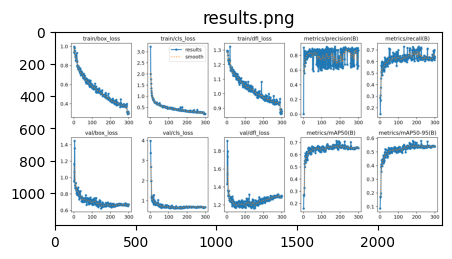

In [10]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/results.png")

### **F1-Confidence Score & Curve :**

In [12]:
print("F1 score:", training_results.box.f1)

F1 score: [    0.90286     0.61204     0.91159     0.70029     0.31771]


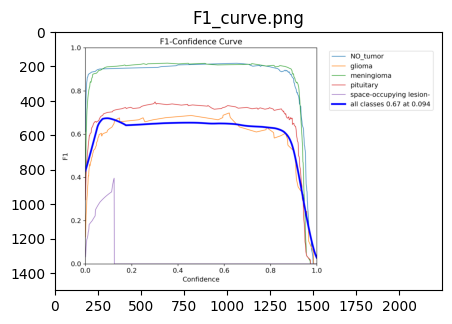

In [13]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/F1_curve.png")

### **Precision Scores & Curves :**

In [14]:
print("Precision Score:", training_results.box.p)

Precision Score: [     0.8616     0.54712     0.88557     0.62159     0.43572]


In [15]:
print("Class indices with average precision:", training_results.ap_class_index)

Class indices with average precision: [0 1 2 3 4]


In [16]:
print("Average precision for all classes:", training_results.box.all_ap)

Average precision for all classes: [[    0.94575     0.94575     0.94193     0.94193     0.86411     0.80431     0.66866     0.63185     0.54807     0.43259]
 [    0.66394     0.66347      0.5899      0.5899     0.57037     0.51874     0.43065     0.33535      0.2459     0.05633]
 [    0.94729     0.93771     0.92675     0.88859     0.87779     0.86145     0.81151     0.79441     0.73033      0.4512]
 [    0.76147      0.7502     0.74223     0.72107     0.68543     0.66417     0.64238     0.58719     0.41931     0.18074]
 [    0.25144     0.25144     0.25144     0.25144     0.25144     0.25144     0.25144     0.25144     0.25144           0]]


In [17]:
print("Mean precision:", training_results.box.mp)

Mean precision: 0.670319705654476


In [18]:
print("Mean average precision:", training_results.box.map)

Mean average precision: 0.5806738202695093


In [19]:
print("Mean average precision at IoU=0.50:", training_results.box.map50)

Mean average precision at IoU=0.50: 0.7139788624515289


In [20]:
print("Mean average precision at IoU=0.75:", training_results.box.map75)

Mean average precision at IoU=0.75: 0.6200217545257647


In [21]:
print("Mean average precision for different IoU thresholds:", training_results.box.maps)

Mean average precision for different IoU thresholds: [    0.77249     0.46645      0.8227     0.61542      0.2263]


In [22]:
print("Precision values:", training_results.box.prec_values)

Precision values: [[          1           1           1 ...    0.020873    0.010436           0]
 [          1           1           1 ...  0.00069117  0.00034558           0]
 [          1           1           1 ...    0.012517   0.0062585           0]
 [          1           1           1 ...   0.0039239   0.0019619           0]
 [          1           1           1 ...  4.5243e-05  2.2621e-05           0]]


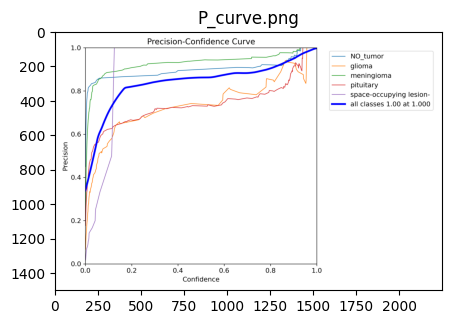

In [23]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/P_curve.png")

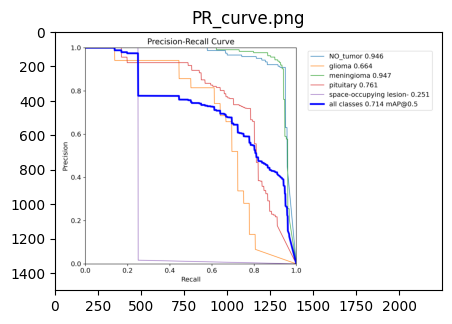

In [24]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/PR_curve.png")

### **Recall Scores & Curve :**

In [25]:
print("Recall:", training_results.box.r)

Recall: [    0.94828     0.69444     0.93919      0.8018        0.25]


In [26]:
print("Mean recall:", training_results.box.mr)

Mean recall: 0.7267422595008801


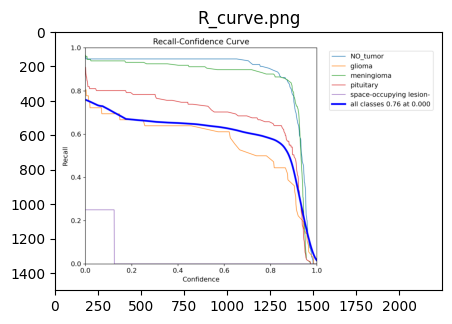

In [27]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/R_curve.png")

### **Confusion Matrix :**

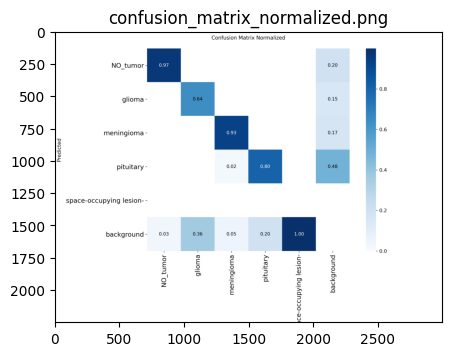

In [28]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/confusion_matrix_normalized.png")

### **Labels & Labels-Correlogram :**

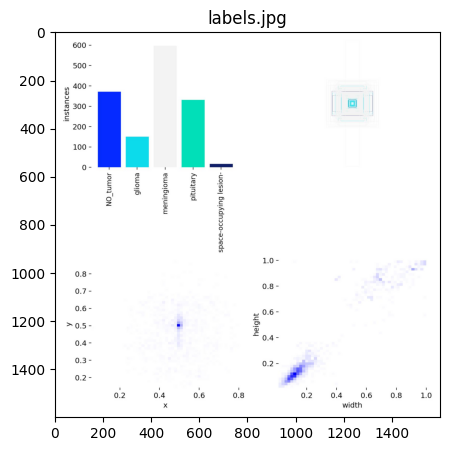

In [29]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/labels.jpg")

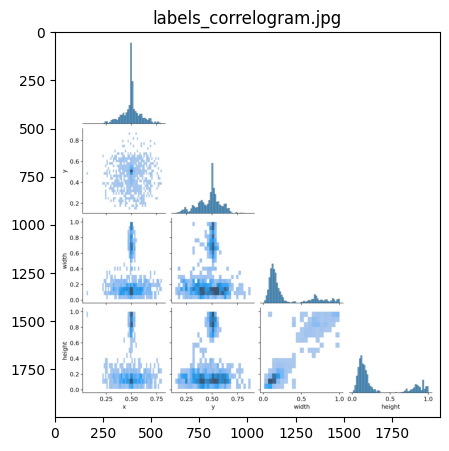

In [30]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/labels_correlogram.jpg")

### **Some Train Batch Sample Result :**

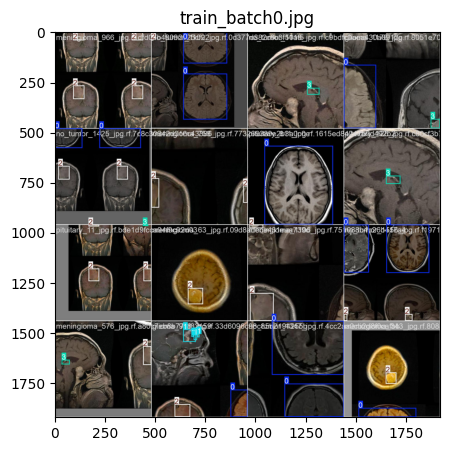

In [31]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/train_batch0.jpg")

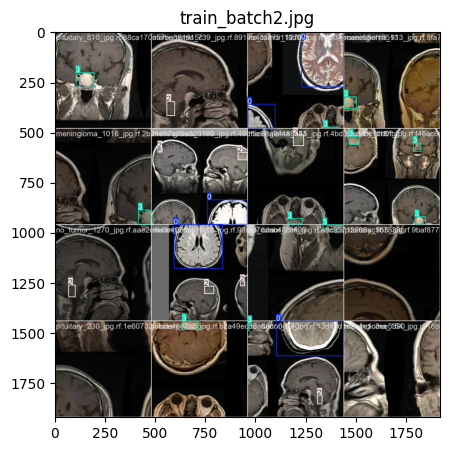

In [32]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/train_batch2.jpg")

### **Some Validation Batch Results :(labels & Predict)**

#### **Batch-0 (labels & Predict) :**

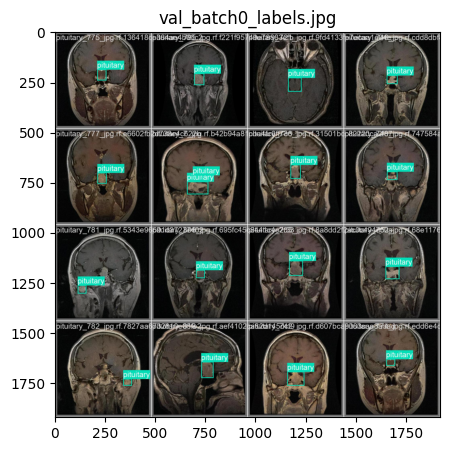

In [33]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/val_batch0_labels.jpg")

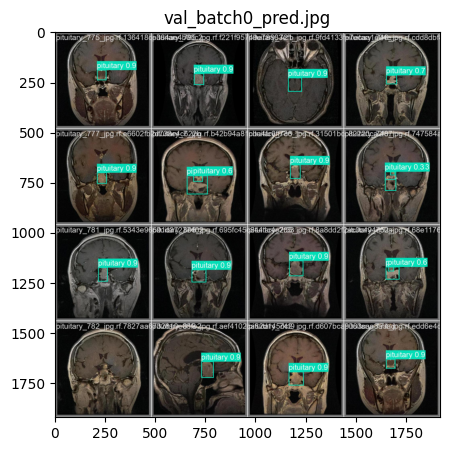

In [34]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/val_batch0_pred.jpg")

#### **Batch-2 (labels & Predict) :**

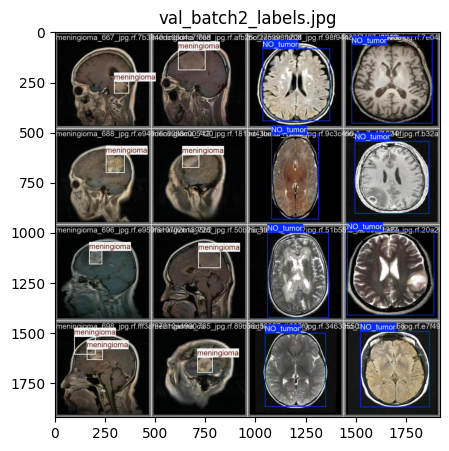

In [35]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/val_batch2_labels.jpg")

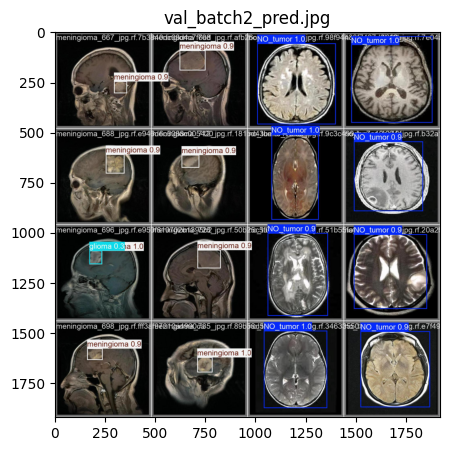

In [36]:
results_display_function(path="/kaggle/working/runs/detect/Brain-Tumor-Detection/val_batch2_pred.jpg")

# **Running Inference On The Fine-Tuned Model Using Test Data From Dataset :**

In [37]:
def load_test_data_from_roboflow_dataset(dataset_path, max_images):
    if not dataset_path or not os.path.exists(dataset_path):
        print("Dataset path is not found.")
        return None
    
    print("Continue the test data loading process:")

    # open data.yaml file
    try:
        with open(os.path.join(dataset_path,"data.yaml"), 'r') as f:
            yaml_file=yaml.safe_load(f)
        print("data.yaml loaded successfully.")
    except Exception as e:
        print(f"Error occurred during load the data.yaml file: {e}")
        return None 
    
    # Get the test images from dataset yaml file
    try:
        test_data_dir=None
        if 'test' in yaml_file:
            test_data_dir = yaml_file['test'] if os.path.isabs(yaml_file['test']) else os.path.join(dataset_path, yaml_file['test'])
        elif 'val' in yaml_file:
            test_data_dir = yaml_file['val'] if os.path.isabs(yaml_file['val']) else os.path.join(dataset_path, yaml_file['val'])
        else:
            print("Neither 'test' nor 'val' directories are specified in yaml file.")
            return None

        if not os.path.exists(test_data_dir):
            print(f"No valid test directory [{test_data_dir}] has been found.")
            return None

        if len(os.listdir(test_data_dir))== 0:
            print(f"Test directory [{test_data_dir}] is empty.")
            return None

        img_ext=('.jpg', '.png', '.jpeg', '.bmp', '.gif')
        load_images=[os.path.join(test_data_dir, img) 
                     for img in os.listdir(test_data_dir)
                     if os.path.isfile(os.path.join(test_data_dir, img)) # check for valid images
                     and img.lower().endswith(img_ext)] 
        
        # Take max images after filtering all valid images
        if load_images is not None:
            load_images = load_images[:max_images]
        
        if not load_images:
            print("Not valid Images have been found in test directory.")
            return None
        
        print("Images loaded successfully for testing.")
    except Exception as e:
        print(f"Error occurred during load the images from data.yaml file: {e}")
        return None 
    
    return load_images

In [38]:
testing_images = load_test_data_from_roboflow_dataset(dataset_path="/kaggle/working/Tumor-Detection-8",max_images=10) # if we want to run inference on first 5 val or test images
# testing_images=load_test_data_from_roboflow_dataset(dataset_path="/kaggle/working/Vehicle-Monitoring-System--4",max_images=None) # if we want to run inference on all val or test images

Continue the test data loading process:
data.yaml loaded successfully.
Images loaded successfully for testing.


In [39]:
def test_best_model(best_model_path, run_name, testing_images): 
    if not best_model_path or not os.path.exists(best_model_path):
        print("Trained model path is not found.")
        return None
    else:
        print("Continued the best model testing process :")
    
    # Load the best model 
    try:
        best_model=YOLO(best_model_path)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error occurred during load the best model {e}")
        return None

    # Create a directory to save the inference result
    try:
        results_dir=f"/kaggle/working/inference/{run_name}_test_data"
        os.makedirs(results_dir, exist_ok=True)
        print("results_dir created  successfully.")
    except Exception as e:
        print(f"Error occurred during create the results_dir {e}")
        return None

    result_paths=[]
    
    # Run the prediction on each test data images and display results 
    for idx, img_path in enumerate(testing_images):
        filename = os.path.basename(img_path)
        print(f"\nProcessing: [{filename}]")
        try:
            results = best_model(img_path, save=True, project=results_dir, name=f"predict{idx+1}")
        except Exception as e:
            print(f"Error occurred during testing with the best model: {e}")
            continue 
        
        try:
            result_file_subdir=os.path.join(results_dir, f"predict{idx+1}")
            result_file_path=os.path.join(result_file_subdir, filename)
            result_paths.append(result_file_path)
        except Exception as e:
            print(f"Error occurred during save the results in this [{result_path}] path: {e}")
            continue
            
    return result_paths # return all process image path

In [40]:
result_paths = test_best_model(best_model_path="/kaggle/working/runs/detect/Brain-Tumor-Detection/weights/best.pt", run_name=run_name, testing_images=testing_images)

Continued the best model testing process :
Model loaded successfully.
results_dir created  successfully.

Processing: [meningioma_736_jpg.rf.c9a572f1cf4c209e0753c703738acf07.jpg]

image 1/1 /kaggle/working/Tumor-Detection-8/test/images/meningioma_736_jpg.rf.c9a572f1cf4c209e0753c703738acf07.jpg: 640x640 1 meningioma, 15.4ms
Speed: 1.7ms preprocess, 15.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/Brain-Tumor-Detection_test_data/predict1

Processing: [no_tumor_1514_jpg.rf.5283527681bc5c241a570fcaf45db988.jpg]

image 1/1 /kaggle/working/Tumor-Detection-8/test/images/no_tumor_1514_jpg.rf.5283527681bc5c241a570fcaf45db988.jpg: 640x640 1 NO_tumor, 14.2ms
Speed: 1.6ms preprocess, 14.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/Brain-Tumor-Detection_test_data/predict2

Processing: [no_tumor_402_jpg.rf.abf3c53989455ff55ba4caf865098116.jpg]

image 1/1 /kaggle/workin

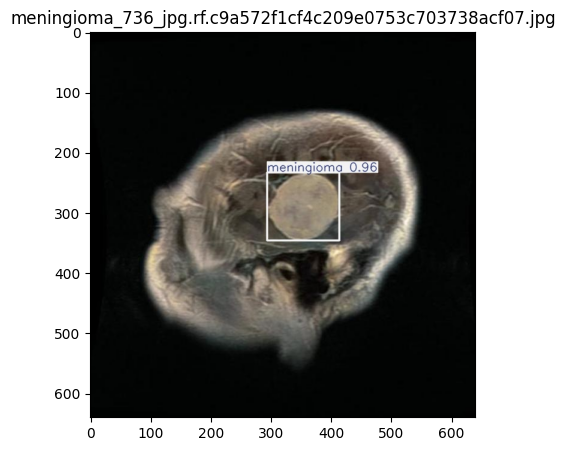

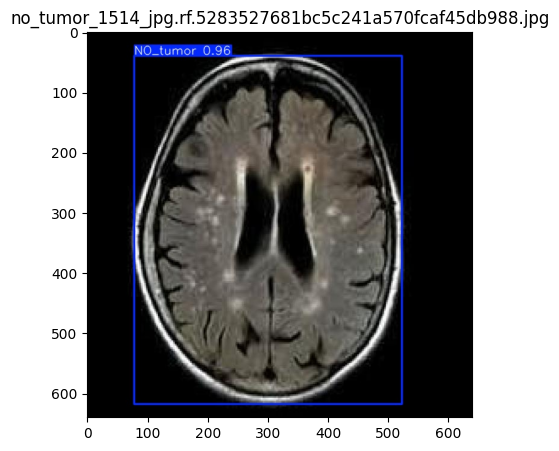

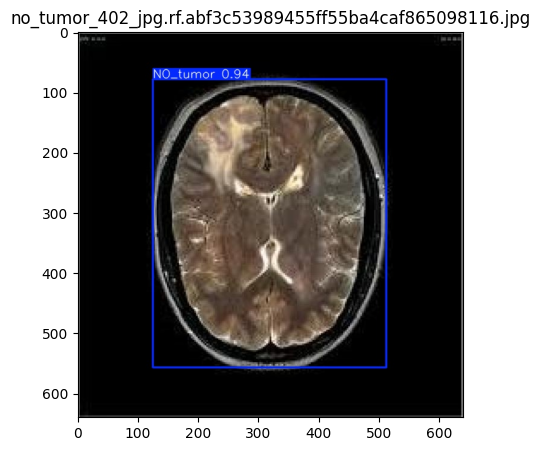

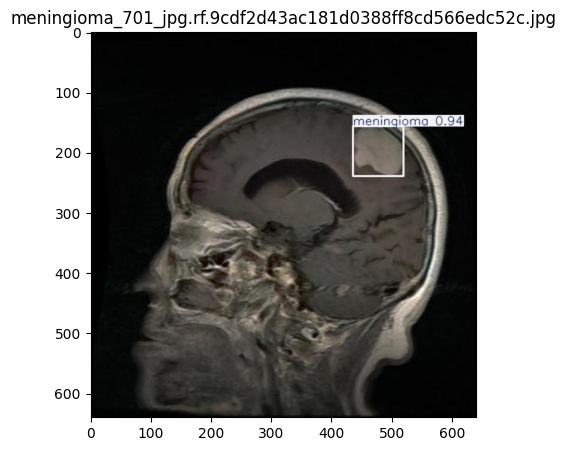

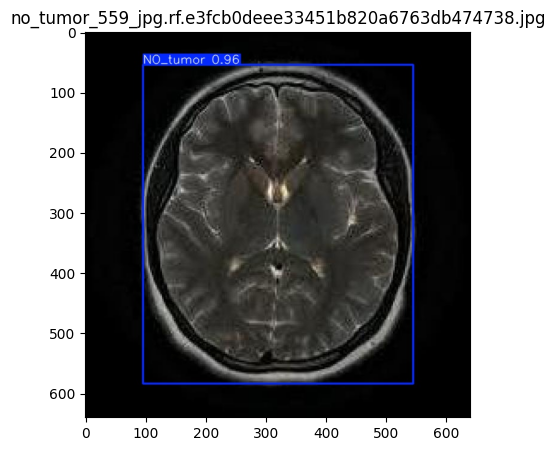

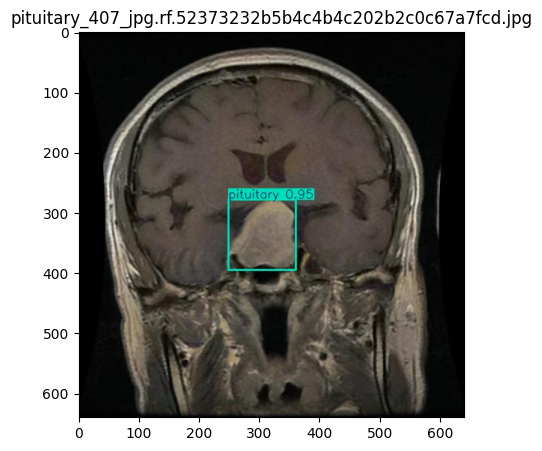

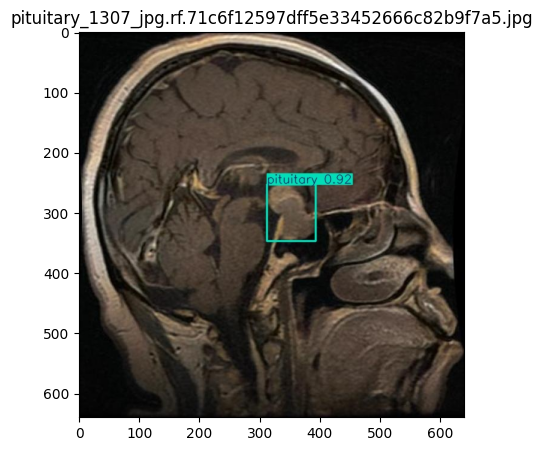

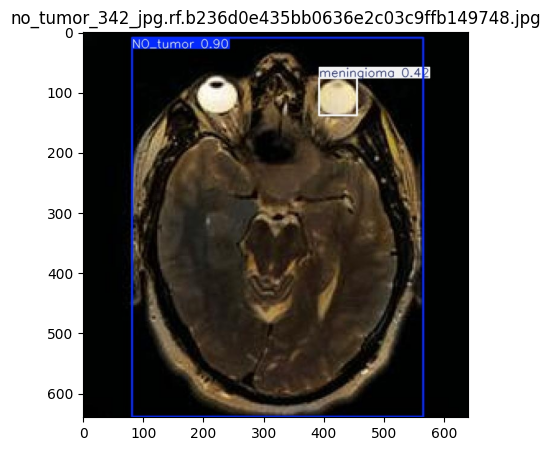

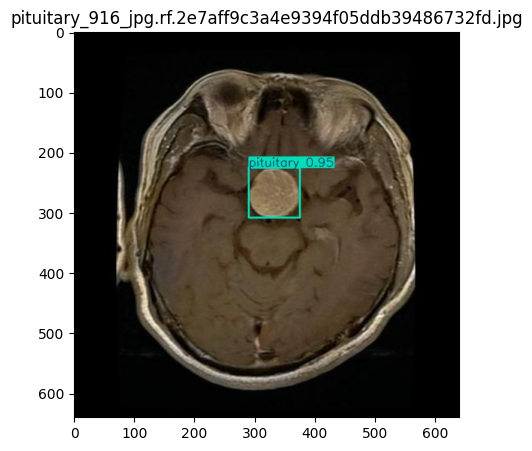

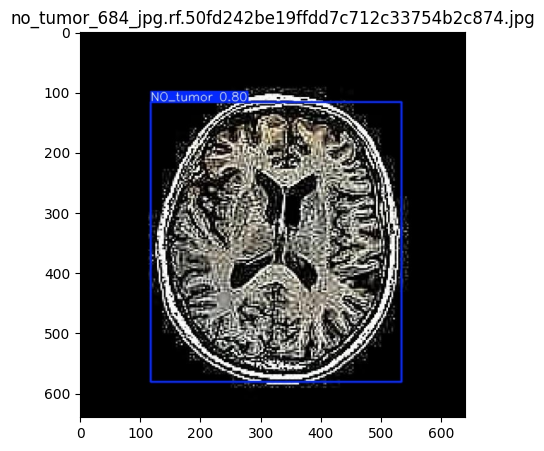

In [41]:
results_display_function(path=result_paths)

# **Running Inference On The Fine-Tuned Model Using Unseen Raw Data :**

In [42]:
def load_and_preprocess_unseen_data(raw_images_path, max_images, conv_output_dir):
    if not raw_images_path or not os.path.exists(raw_images_path):
        print("Images or Image path is not found.")
        return None
    
    print("Continue the unseen test data loading process:")

    img_ext=('.jpg', '.png', '.jpeg', '.bmp', '.gif', '.jfif')

    # create output directory for converted images 
    if not os.path.exists(conv_output_dir):
        os.makedirs(conv_output_dir)
    
    img_file = []

    # Check the input type (like file or directory)
    try:
        if os.path.isfile(raw_images_path) and raw_images_path.lower().endswith(img_ext):
            img_file=[raw_images_path] # Single image
        elif os.path.isdir(raw_images_path):
            img_file=[os.path.join(raw_images_path,img) for img in os.listdir(raw_images_path) if img.lower().endswith(img_ext)] 
            if max_images is not None: # it will execute when max_value will be given 
                img_file = img_file[:max_images] # Take first 'n' number of images 
        else:
            print("'Warning'....Provide a valid image file or directory.")
    
        if not img_file:
            print(f"Not valid Images have been found in test directory [{raw_images_path}].")
            return None

        # convert images to .jpg and save in conv_output_dir , skip for .jpg files
        converted_img_paths=[]
        for img_path in img_file:
            base_name=os.path.splitext(os.path.basename(img_path))[0]
            out_path=os.path.join(conv_output_dir, f"{base_name}.jpg")

            # if file is already .jpg then use original path
            if img_path.lower().endswith('.jpg'):
                converted_img_paths.append(img_path)
                continue

            # open file and convert other file to .jpg
            try:
                with Image.open(img_path) as img:
                    # convert to RGB for PNG file 
                    if img.mode in ('RGBA', 'LA', 'P'):
                        img= img.convert('RGB')
                    # save as .jpg file
                    img.save(out_path, 'JPEG', quality=95)
                converted_img_paths.append(out_path)
            except Exception as e:
                print(f"Error occurred during converting image {img_path}: {e}")
                continue 
                
        if not converted_img_paths:
            print("No images were loaded or converted.")
            return None

        print("Images loaded and converted to .jpg successfully and ready for testing.")
        return converted_img_paths
    
    except Exception as e:
        print(f"Error occurred during loading or converting images: {e}")
        return None

In [54]:
# img_file = load_and_preprocess_unseen_data(raw_images_path="/kaggle/input/raw-unseen-data-for-testing", max_images=5, conv_output_dir="/kaggle/working/converted_images") # if we take a directory of images and want to run inference on first 5 images
img_file = load_and_preprocess_unseen_data(raw_images_path="/kaggle/input/raw-unseen-data-for-testing", conv_output_dir="/kaggle/working/converted_images", max_images=None) # if we take a directory of images and want to run inference on all images

Continue the unseen test data loading process:
Images loaded and converted to .jpg successfully and ready for testing.


In [55]:
un_result_paths = test_best_model(best_model_path=best_model_path, run_name="Brain-Tumor-Detection_raw_unseen_test_data", testing_images=img_file)

Continued the best model testing process :
Model loaded successfully.
results_dir created  successfully.

Processing: [mri_gbm3.jpg]

image 1/1 /kaggle/input/raw-unseen-data-for-testing/mri_gbm3.jpg: 640x576 1 glioma, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)
Results saved to /kaggle/working/inference/Brain-Tumor-Detection_raw_unseen_test_data_test_data/predict14

Processing: [images (2).jpg]

image 1/1 /kaggle/input/raw-unseen-data-for-testing/images (2).jpg: 640x544 1 meningioma, 14.2ms
Speed: 1.7ms preprocess, 14.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)
Results saved to /kaggle/working/inference/Brain-Tumor-Detection_raw_unseen_test_data_test_data/predict22

Processing: [article_river_8f970950815b11ec9f017df5f589948d-Figure1.jpg]

image 1/1 /kaggle/working/converted_images/article_river_8f970950815b11ec9f017df5f589948d-Figure1.jpg: 544x640 1 NO_tumor, 14.3ms
Speed: 2.2ms preprocess, 14.3ms infe

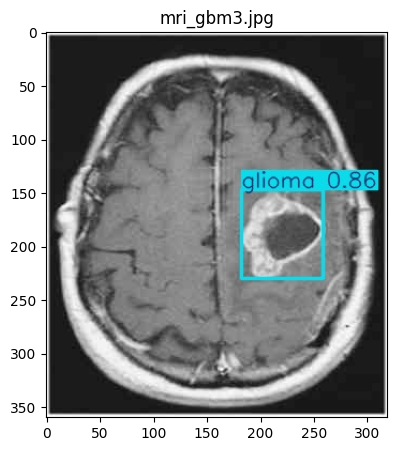

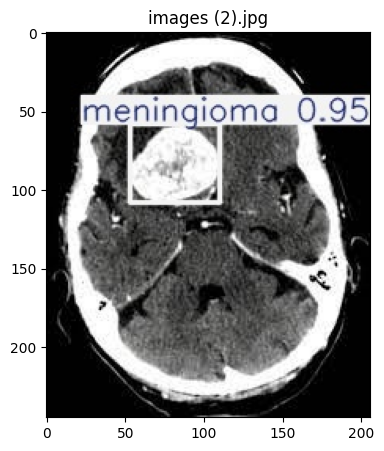

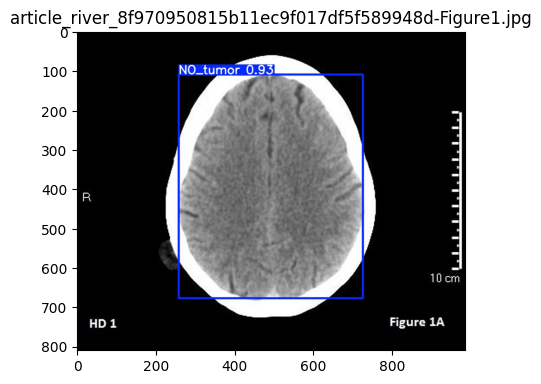

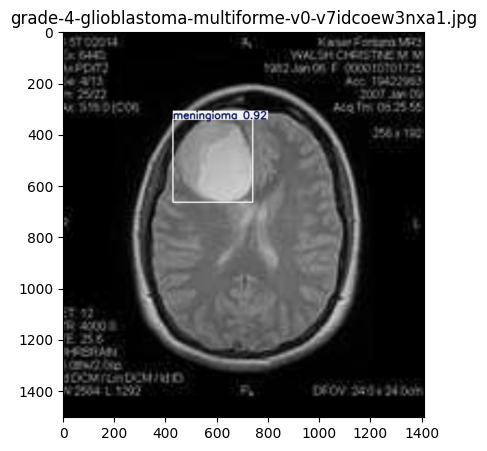

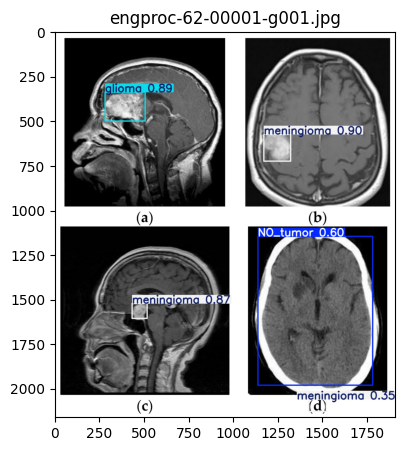

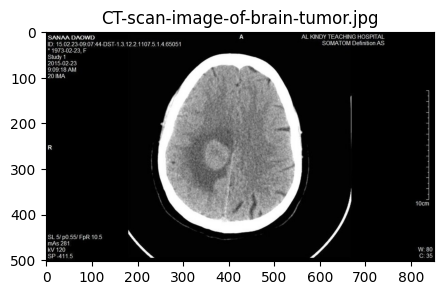

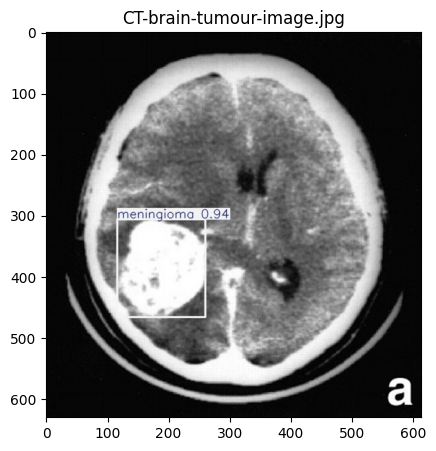

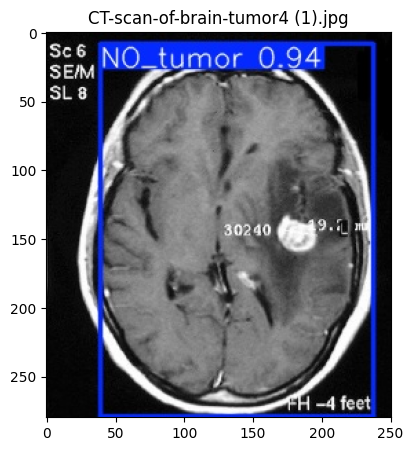

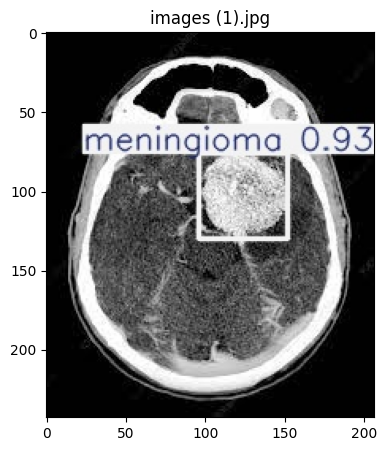

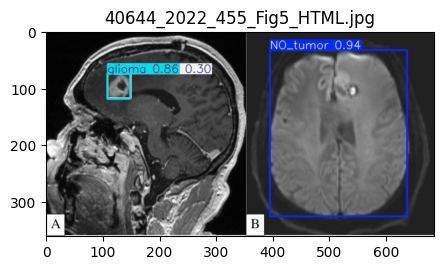

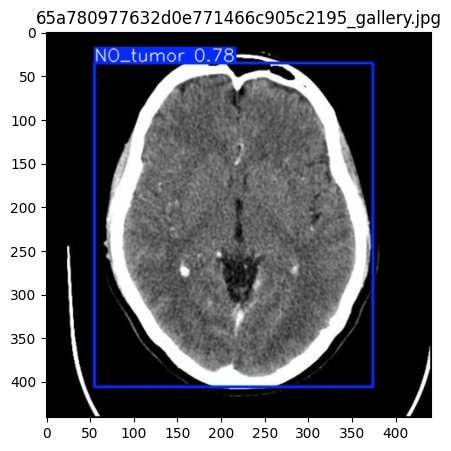

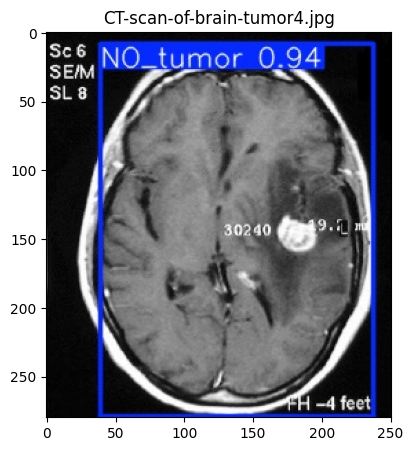

In [56]:
results_display_function(path=un_result_paths)